# Линейная регрессия
1. Постановка задачи
2. Обучение
3. Тестирование и оценка качества

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

## 1. Постановка задачи
Рассмотрим данные медицинского страхования:
+ каждая строка - признаки для каждого клиента страховой организации
+ **Задача**: предсказать *индивидуальные медицинские расходы* по отдельным признакам

In [9]:
# загрузим данные
# укажем столбец, в котором даты - чтобы их спарсить как даты
data = pd.read_csv('insurance_miptstats.csv', parse_dates=[0])
data.head()

,birthday,sex,bmi,children,smoker,region,charges
0,2001-12-20,female,27.900,0,yes,southwest,16884.92400
1,2003-03-18,male,33.770,1,no,southeast,1725.55230
2,1992-11-02,male,33.000,3,no,southeast,4449.46200
3,1987-07-27,male,22.705,0,no,northwest,21984.47061
4,1988-11-04,male,28.880,0,no,northwest,3866.85520


In [10]:
# смотрим на размер таблицы
data.shape

(1338, 7)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   birthday  1338 non-null   datetime64[ns]
 1   sex       1338 non-null   object        
 2   bmi       1338 non-null   float64       
 3   children  1338 non-null   int64         
 4   smoker    1338 non-null   object        
 5   region    1338 non-null   object        
 6   charges   1338 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 73.3+ KB


Тестировать качество модели всегда нужно на тех данных, которые не учавствовали в обучении. Такие данные называем **тестовые**.

Данные, которые участвуют в обучении называются **обучающими**

Разбиение выборки на обучающую и тестовую - с помощью **train_test_split**

In [11]:
train, test = train_test_split(data, test_size=0.2)
train.shape, test.shape

((1070, 7), (268, 7))

## 2. Обучение

In [14]:
pd.Timestamp.now().date()

datetime.date(2024, 4, 12)

In [19]:
pd.Timedelta('1Y')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


Timedelta('365 days 05:49:12')

In [20]:
# вычислим возраст каждого человека
# дабы не было утечек - только по обучающей выборке
train['age'] = (pd.Timestamp.now() -  train['birthday']) / pd.Timedelta('1Y')
train.head()

,birthday,sex,bmi,children,smoker,region,charges,age
89,1965-11-03,female,26.980,0,no,northwest,11082.57720,58.441948
935,1962-03-14,female,27.500,0,no,southwest,12233.82800,62.083365
1320,1989-06-20,male,31.065,3,no,northwest,5425.02335,34.813811
555,1992-07-24,male,23.800,2,no,southwest,3847.67400,31.719976
171,1972-01-22,male,30.300,0,no,southwest,8116.68000,52.224162


In [24]:
# выделим категории признаков
categorial_features = ['sex', 'smoker', 'region'] # категориальные признаки
real_features = ['age', 'bmi', 'children'] # вещественные признаки
target_feature ='charges' # целевой признак

Используем **PairGrid** для визуализации совместныъ распределений вещественных признаков

Будем разбивать данные по одному признаку из числа категориальных. Графики будут:
+ данные в виде точек для каждой пары вещественных признаков
+ ядерные оценки плотности для каждой пары вещественных признаков
+ ядерные оценки плотности для всех вещественных признаков по отдельности

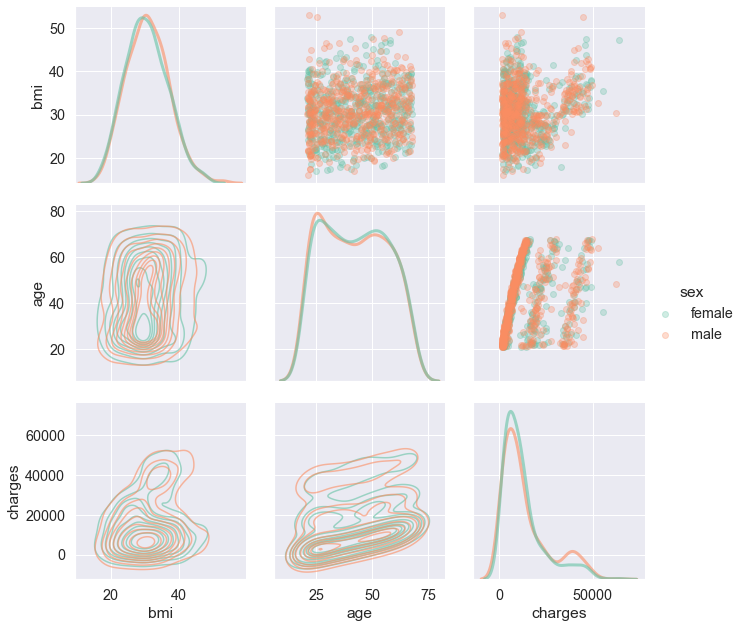

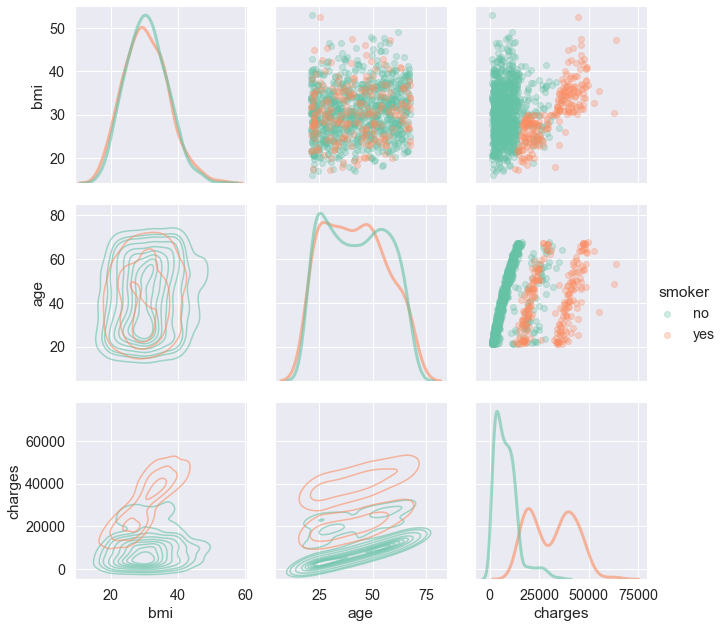

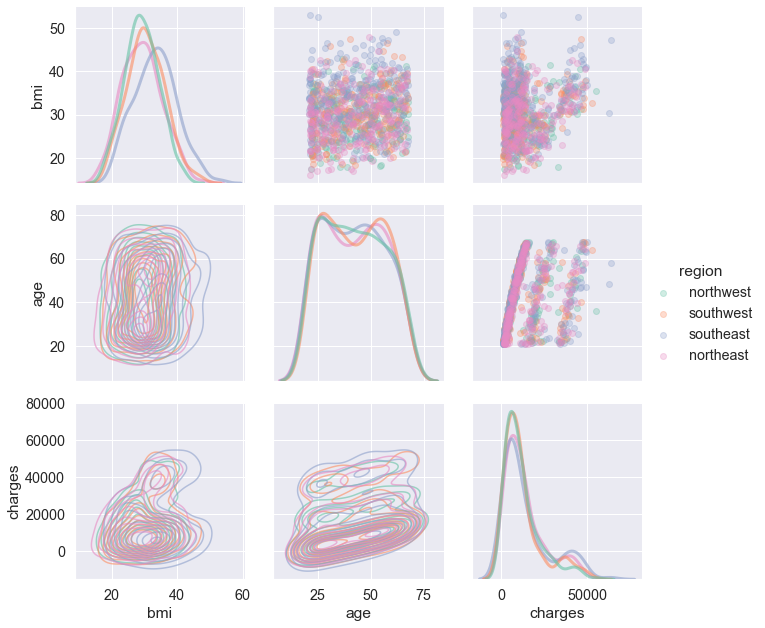

In [30]:
for hue in categorial_features:
    g = sns.PairGrid(train[['bmi', 'age', 'charges', hue]],
                     hue=hue, 
                     diag_sharey=False,
                     height=3)
    
    g.map_lower(sns.kdeplot, alpha=0.6)
    g.map_upper(plt.scatter, alpha=0.3)
    g.map_diag(sns.kdeplot, lw=3, alpha=0.6, common_norm=False)
    
    g.add_legend()

Из графиков мы видим:
+ расходы растут с увеличением возраста клиента
+ величина расходов больше для курящих людей

Предполагаем, что эти признаки должны оказать существенную влияние при построении регрессионной модели

### OneHotEncoder
**Закодируем** категориальные признаки с помощью класса **OneHotEncoder**
+ метод делает из одного категориального признака несколько бинарных признаков - по количеству различных значений исходного категориального признака

Если исходный признак принимал 5 различных значений - то его кодировкой будет 5 новых бинарных признаков:
+ 1 у того бинарного признака, который соотвествует данному значению исходного категориального признака
+ 0 у всех остальных

В случае линейной регрессии - необходимо делать на один бинарный признак *меньше*, так как значения сотавшегося бинарного признака можно выразить из значений всех остальных бинарных признаков

**Важные аргументы конструктора**:
+ `categories` - если установленно `auto`, то категории определяются по имеющемуся объему данных. Иначе - используем список катеорий, который передается этим аргументом
+ `drop` - указывем методику, используемую для удаления одной из категорий для каждого объекта. Это может быть полезно для некоторых моделей, например, для линейной регрессии. Возможные значения:
    + `None` - оставляем все признаки
    + `first` - удаляет первую категорию для каждого признака. Если признак имеет одну категорию, то он будет полностью удален
    + `if_binary` - удаляет первую категорию только для бинарных признаков
    + массив `drop`, где `drop[i]` - категория в признаке feature `X[:,i]`, которая должна быть удалена
+ `sparse` - возвращает sparse-матрицу, если установлено значение `True`, иначе - массив

**Основные методы класса**:
+ `fit(x)` - обучить кодировощик кодировать признаки на основе данных `X` (т.е. опеделить функции кодирования и декодирования признаков)
+ `transform(X)` - закодировать признаки в данных `X`
+ `fit_transform(X)` - обучить кодировщик по данным `X` и сразу их закодировать
+ `inderse_transform(X)` - декодировать признаки в данных `X`, т.е. перевести бинарные признаки в исходные категориальные

При построении кодировщика учтем ряд особенностей:
+ указываем `drop="first"`, т.е. одну категорию нужно исключить
+ указываем `sparse=False`, т.е. вернуть нужно неразреженную матрицу
+ нужно выполнить *обучение*, что в данном случае подразуемевает построение и сохранение правила преобразования
+ сразу же кодируем признаки из обучающего множества

In [32]:
encoder = OneHotEncoder(drop='first', sparse=False) # объявляем модель
train_cat = encoder.fit_transform(train[categorial_features]) # обучаем и кодируем
train_cat

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.]])

посмотрим на то, как у нас *обучились* категории.

Для каждого признака приведен список его категорий:

In [33]:
encoder.categories_

[array(['female', 'male'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

Соединим вместе вещественные признаки и закодированные категориальные.

Используем функцию np.hstack - которая конкатенирует столбцы

In [34]:
X_train = np.hstack([train[real_features], train_cat])
X_train.shape

(1070, 8)

### LinearRegression
Обучаем саму модель линейной регрессии с помощью класса **LinearRegression**

**Важные аргументы конструктора**:
+ `fit_intercept` - нужно ли включать в модель свободный член.
    + `fit_intercept=True` - по умолчанию, тогда не нужно передавать признак из всех единиц, чтобы она оценивала свободный член
+ `normalize` - нужно ли сделать нормализацию данных. Она делается по умолчанию в случае `fit_intercept=True`

**Основные методы класса**
+ `fit(X,y)` - обучить линейную регрессию на основе данных `X` предсказывать целевой признак `y`. В данном случае под термином "обучить" понимается вычисление оценки коэффициентов $\hat{\theta}$
+ `predict(X,y)` - предсказать по данным `X` целевой признак `y`. В данном случае под термином "предсказать" понимается вычисление оценки целеового признака $\hat y$



In [35]:
model = LinearRegression(fit_intercept=True) # объявляем модель
model.fit(X_train, train[target_feature]) # обучаем

LinearRegression()

Посмотрим на результат обучения. Оценки коэффициентов перед признаками:

In [36]:
model.coef_

array([  257.57032654,   329.62451203,   509.88241562,    61.4381691 ,
       23443.54827232,  -635.17037507, -1201.27559706,  -952.89931947])

Оценка свободного коэффициента

In [37]:
model.intercept_

-12567.148630843125

## 3. Тестирование и оценка качества

Выполним теже преобразования с тестовым множеством

In [39]:
# Получим возраст клиента по дате рожления
test['age'] = (pd.Timestamp.now() -  test['birthday']) / pd.Timedelta('1Y')

# Кодируем категориальыне признаки с помощью метода transform обученного ранее кодировщика
test_cat = encoder.transform(test[categorial_features])

# Соединяем данные
X_test = np.hstack([test[real_features], test_cat])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


Выполним **предсказание** построенной ранее модели с помощью метода `predict`

In [40]:
test_preds = model.predict(X_test)

Для подсчета **ошибки предсказания** есть разные способы:
+ **MSE** (mean squared error) - самая популярная метрика. $\displaystyle MSE = \frac{1}{n}\sum_{i=1}^n\left (Y_i-\hat Y_i\right)^2$
+ **RMSE** - квадратный корень из **MSE**
+ **MAE** (mean absolute error) $\displaystyle MAE = \frac{1}{n}\sum_{i=1}^n |Y_i-\hat Y_i|$
+ **MAPE** (mean absolute percentage error) $\displaystyle MAPE = 100\% \frac{1}{n}\sum_{i=1}^n \frac{|Y_i-\hat Y_i|}{Y_i}$

In [41]:
# подсчитаем RMSE
np.sqrt(((test[target_feature] - test_preds) ** 2).mean())

5834.463701071148

Смысл значения **RMSE** - показать, на сколько в среднем модель отклоняется от истинного значения

Готовая реализация метрик есть в `sklearn`:

In [44]:
metrics.mean_squared_error(test[target_feature], test_preds) ** 0.5

5834.463701071148

In [46]:
# функция для расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()

mean_absolute_percentage_error(test[target_feature], test_preds)

37.497184480280644

In [47]:
# Для сравнения - посчитаем предсказания и ошибки на обучающем множестве
train_preds = model.predict(X_train)

metrics.mean_squared_error(train[target_feature], train_preds) ** 0.5, \
metrics.mean_absolute_error(train[target_feature], train_preds),\
mean_absolute_percentage_error(train[target_feature], train_preds)

(6097.152279659013, 4245.73362277006, 42.56851502708266)